In [1]:
#jupyter notebook --NotebookApp.max_buffer_size=your_value
#jupyter notebook --NotebookApp.max_buffer_size= 6291456000
#jupyter notebook --NotebookApp.max_buffer_size=6442450944 #this
#import psutil
#psutil.virtual_memory()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as sstat
from mpmath import mp
import math
import random
from scipy.stats import multivariate_normal
from sklearn import preprocessing as p

psd = pd.DataFrame
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

2022-02-14 00:50:19.181687: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-14 00:50:19.181717: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# parallelization modules 
import os
import time
import tensorflow.random as tfr
from multiprocessing import Process, Queue, SimpleQueue

In [4]:
def prior_unif():
  return tfd.Uniform(0,10)

In [5]:
def prior_out(theta):
  a= theta[0]
  b= theta[1]
  g= theta[2]
  k= theta[3]
  a_prior = tfd.Uniform(0,10).prob(a)
  b_prior = tfd.Uniform(0,10).prob(b)
  g_prior = tfd.Uniform(0,10).prob(g)
  k_prior = tfd.Uniform(0,10).prob(k)
  return  a_prior *b_prior * g_prior*  k_prior 

In [6]:
def my_kernel(u):
  return 1/(np.sqrt(2*math.pi))*np.exp(-1/2*u**2)

In [7]:
def K_h(u,h):
  return my_kernel(u/h)/h

In [8]:
def S2(y):
  quantiles= np.zeros(9)
  for i in range(9):
      quantiles[i]= np.quantile(y,0.1+0.1*i)       #quantili 0,1 0,2 0,3 0,4 0,5 0,6 0,7 0,8 0,9
  return quantiles

In [9]:
def S1(y):
  return np.mean(y)

In [10]:
from scipy.spatial import distance

def distance(s_old, s_obs):
   return np.linalg.norm(s_old-s_obs)
   # return distance.mahalanobis(s_old, s_obs, iv)

      

In [11]:
def quantile_fun(theta,z):
    a= theta[0]
    b= theta[1]
    g= theta[2]
    k= theta[3]
    y = a+b*(1+0.8*(1-np.exp(-g*z))/(1+np.exp(-g*z)))*((1+z**2)**k)*z
    return y

In [12]:
def quantile_fun_param(a,b,g,k,z):
    y = a+b*(1+0.8*(1-np.exp(-g*z))/(1+np.exp(-g*z)))*((1+z**2)**k)*z
    return y

In [13]:
##MAXIMAL COUPLING OF THETA
def maximal_coupling(x,y):
      current_x = x
      current_y = y  
      const=0.1
      proposed_x = current_x  + np.random.multivariate_normal(np.zeros(4),const*np.identity(4))
      pX = sstat.multivariate_normal.pdf(proposed_x,current_x,np.identity(4))
      w = tfd.Uniform(0,1).sample()*pX
      qX = sstat.multivariate_normal.pdf(proposed_x,current_y,np.identity(4))
      #print('w',w,'qX',qX,'x',current_x,'y', current_y)
      if w < qX:
          x_new = proposed_x
          y_new = proposed_x
       
      else:
          t = True
          while t == True:
                proposed_y = current_y   + np.random.multivariate_normal(np.zeros(4),const*np.identity(4))
                qY =  sstat.multivariate_normal.pdf(proposed_y,current_y,np.identity(4)) 
                w =  tfd.Uniform(0,1).sample()*qY
                pY =sstat.multivariate_normal.pdf(proposed_y,current_x,np.identity(4))
                if w > pY :
                  t = False
          x_new = proposed_x
          y_new = proposed_y  


      return [x_new, y_new]

In [14]:
def prob(H,s_obs,s_current,theta_current,s_i,theta_i):   #s[i,],a[i]
  NUM = (K_h(distance(np.array(s_current), np.array(s_obs)),H)*prior_out(theta_current))
  DEN = (K_h(distance(np.array(s_i),np.array(s_obs)),H)* prior_out(theta_i))
  return NUM/DEN    

In [15]:
np.array([1,1,0.1,1])

array([1. , 1. , 0.1, 1. ])

In [16]:
def abc_coupling_gandk(N, S, y_obs,h):
##INITIALIZATION:
    s_obs = S(y_obs)
    s1 = np.zeros((N+1,9))
    s2 = np.zeros((N+1,9))
    y1 = np.zeros(n)
    y2 = np.zeros(n)
    y1_current = np.zeros(n)
    y2_current = np.zeros(n)
    theta1=np.zeros((N+1,4))
    theta2=np.zeros((N+1,4))
    rate1=0
    rate2=0
    a1_0 =prior_unif().sample(1)
    b1_0 =prior_unif().sample(1)
    g1_0 =prior_unif().sample(1)
    k1_0 =prior_unif().sample(1)
    a2_0 =prior_unif().sample(1)
    b2_0 =prior_unif().sample(1)
    g2_0 =prior_unif().sample(1)
    k2_0 =prior_unif().sample(1)

# STARTING POINT:
    for i in range(n):
      z = tfd.Normal(0,1).sample() 
      y1[i]=quantile_fun_param(a1_0,b1_0,g1_0,k1_0,z)
    s1_0 = S(y1)

    for i in range(n):
      z = tfd.Normal(0,1).sample() 
      y2[i]=quantile_fun_param(a2_0,b2_0,g2_0,k2_0,z)
    s2_0 = S(y2)
   
    H=h
    #while K_h(mahal(np.array(s_0),np.array(s_obs)),H)<=0:
    while K_h(distance(np.array(s1_0),np.array(s_obs)),H)<=0:    
        a1_0 =prior_unif().sample(1)
        b1_0 =prior_unif().sample(1)
        g1_0 =prior_unif().sample(1)
        k1_0 =prior_unif().sample(1)
        for j in range(n):
          z = tfd.Normal(0,1).sample()
          y1[j]=quantile_fun_param(a1_0,b1_0,g1_0,k1_0,z)
        s1_0 = S(y1)
   
    theta1[0,:]=[a1_0,b1_0,g1_0,k1_0]

    while K_h(distance(np.array(s2_0),np.array(s_obs)),H)<=0:    
        a2_0 =prior_unif().sample(1)
        b2_0 =prior_unif().sample(1)
        g2_0 =prior_unif().sample(1)
        k2_0 =prior_unif().sample(1)
        for j in range(n):
          z = tfd.Normal(0,1).sample()
          y2[j]=quantile_fun_param(a2_0,b2_0,g2_0,k2_0,z)
        s2_0 = S(y2)
   
    theta2[0,:]=[a2_0,b2_0,g2_0,k2_0]
    
# ACTUAL IMPLEMENTATION
    for i in range(N):
        
        theta1_current,theta2_current = maximal_coupling(theta1[i,],theta2[i,])
           
        for j in range(n):
          z = tfd.Normal(0,1).sample() 
          y1_current[j] = quantile_fun(theta1_current,z)
          y2_current[j] = quantile_fun(theta2_current,z)
        s1_current = S(y1_current)
        s2_current = S(y2_current)

       
        #den_num=tfd.Normal(theta_muold,1).prob(theta_mucurrent)*tfd.Normal(theta_tauold,1).prob(theta_taucurrent)
        #den_den=tfd.Normal(theta_mucurrent,1).prob(theta_muold)*tfd.Normal(theta_taucurrent,1).prob(theta_tauold)
        
        prob1 = prob(H,s_obs,s1_current,theta1_current,s1[i,],theta1[i,])   #s[i,],a[i]unif().prob(a[i]))
        prob2 = prob(H,s_obs,s2_current,theta2_current,s2[i,],theta2[i,])

        acc_prob1 = min([1.,prob1])
        acc_prob2 = min([1.,prob2])
      
        u = tfd.Uniform(0,1).sample()
        if u < acc_prob1:
              theta1[i+1,] = theta1_current
              s1[i+1,] = s1_current
              rate1+=1
        else: 
              theta1[i+1,] = theta1[i,]
              s1[i+1,] = s1[i,]

        if u < acc_prob2:
              theta2[i+1,] = theta2_current
              s2[i+1,] = s2_current
              rate2+=1
        else: 
              theta2[i+1,]=theta2[i,]
              s2[i+1,] = s2[i,]

        
    return theta1,theta2, rate1, rate2

In [17]:
aobs = 3
bobs = 1
gobs = 2
kobs = 0.5
n = 100
h = 0.6
y_obs = np.zeros(n)
for i in range(n):
  z = tfd.Normal(0,1).sample() 
  y_obs[i] = quantile_fun_param(aobs,bobs,gobs,kobs,z)

In [18]:
test_function_h = lambda x: x

In [19]:
def time_averaged_estimator(red_chain, blue_chain, iterations, burnout, meeting_time):
    #this function calculates only the formula at point 3
    
    #first addend
    first_sum = 0
    for i in range(burnout, iterations):
        first_sum += test_function_h(red_chain[i])
    
    #second addend
    second_sum = 0
    if meeting_time-1 > burnout + 1:
        for i in range(burnout + 1, meeting_time):
            # calculing the coefficient, and the min
            coef = (1-burnout)(iterations - burnout + 1)
            if coef > 1:
                coef = 1
            second_sum += coef * (test_function_h(red_chain[i])- test_function_h(blue_chain[i]))
            
    return (1/(iterations - burnout + 1))*first_sum + second_sum

In [20]:
def parallelized_operations(
    iterations, burnout, chains_matching_tolerance, 
    q_chain, q_meeting_time, q_time_averaged_estimator, q_acc_1, q_acc_2):
    
    
    # setting a random seed - otherwise multiprocessing has the same seed and so they end up in the same chains!
    my_seed = int(os.getpid() * time.time()) % 123456789
    np.random.seed( my_seed )
    tfr.set_seed( my_seed )
    
    #running metropolis hastings and obtaining two chains
    red_chain, blue_chain, acc1_all, acc2_all = abc_coupling_gandk(iterations, S2, y_obs, 0.6)  
    #(red_chain, blue_chain) = metropolis_hastings(iterations)
    
    red_chain = np.swapaxes(np.array(red_chain), 0, 1)
    blue_chain = np.swapaxes(np.array(blue_chain), 0, 1)
    
    dimensionality = 4
    
    #finding the meeting time
    meeting_time = iterations + 2
    for i in range(0, iterations-2):
        if (abs(red_chain[:,i]-blue_chain[:,i]).all() < chains_matching_tolerance) & \
            (abs(red_chain[:,i+1]-blue_chain[:,i+1]).all() < chains_matching_tolerance):
            meeting_time = i
            break
    
    #checking if the chains met
    if meeting_time == iterations+2:
        print('Matching did not occurred!')
        print(meeting_time)
        return
    
    #checking if the chains met before burnout
    if meeting_time >= burnout:
        print('Meeting time occurs after burnout iterations!')
        print(meeting_time)
        return
    
    print('This chain is succesfull:' + str(my_seed))
    
    time_averaged_estimation = np.empty(4)
    
    for param in range(4):
        time_averaged_estimation[param] = time_averaged_estimator(
            red_chain[param,:], 
            blue_chain[param,:], 
            iterations, burnout, meeting_time)
    
    #print(red_chain)
    q_chain.put( red_chain )
    q_meeting_time.put( meeting_time )
    q_time_averaged_estimator.put( time_averaged_estimation )
    q_acc_1.put(acc1_all)
    q_acc_2.put(acc2_all)
    
    return

    

In [21]:
np.empty(4).shape

(4,)

In [22]:
# this returns the number of available processors
num_processes = os.cpu_count()
num_processes

# this set the number of iteration, it should be a multiple of the number of available processors
num_batches_set = 32
num_batches = num_batches_set

# this initialize a shared memory between processors
# note of Queue(maxsize = 0)
q_chain = SimpleQueue()
q_meeting_time = SimpleQueue()
q_time_averaged_estimator = SimpleQueue()
q_acc_1 = SimpleQueue()
q_acc_2 = SimpleQueue()

In [23]:

samplings = np.empty([4,0])

time_averaged_estimation_sum = 0
meeting_times = np.empty(0)
correct_chains = 0

acc_1 = np.empty(0)
acc_2 = np.empty(0)

iterations = 600
burnout = 100
# coupling tolerance
chains_matching_tolerance = 1e-1

while num_batches > 0:
    
    print("There are " + str(num_batches) + " left")
    
    if num_batches >= num_processes:
        current_number_processes = num_processes
    else:
        current_number_processes = num_batches
    
    processes = []
    for batch in range(current_number_processes):
        p = Process(
            target = parallelized_operations, 
            args = (iterations, burnout, 
                    chains_matching_tolerance, 
                    q_chain, q_meeting_time, q_time_averaged_estimator, q_acc_1, q_acc_2)
        )
        processes.append(p)

    num_batches -= current_number_processes
    
    # Starting the processes in a batch
    for p in processes:
        p.start()
        time.sleep(0.1)

    # This assures that each process in the batch is complete
    for p in processes:
        p.join()

    #unfolding queues
    while not q_chain.empty():
        red_chain = q_chain.get()
        samplings = np.append(
            samplings,
            red_chain[:, burnout :],
            axis = 1
        )

        meeting_time = q_meeting_time.get()
        time_averaged_estimation = q_time_averaged_estimator.get()
        
        if meeting_time <= burnout: #this to avoid a biased time averaged estimator
            time_averaged_estimation_sum += time_averaged_estimation
            correct_chains += 1
        
        meeting_times = np.append(
            meeting_times,
            meeting_time
        )
        
        acc_1 = np.append(acc_1, q_acc_1.get())
        acc_2 = np.append(acc_2, q_acc_2.get())
    
del q_chain, q_meeting_time, q_time_averaged_estimator,  q_acc_1, q_acc_2
print('All processes are complete!')

There are 32 left


/tmp/ipykernel_6556/1251087141.py:46: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  theta1[0,:]=[a1_0,b1_0,g1_0,k1_0]
/tmp/ipykernel_6556/1251087141.py:46: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  theta1[0,:]=[a1_0,b1_0,g1_0,k1_0]
/tmp/ipykernel_6556/1251087141.py:46: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the

Matching did not occurred!
602
Matching did not occurred!
602
Matching did not occurred!
602
Matching did not occurred!
602
This chain is succesfull:35421957
Matching did not occurred!
602
Matching did not occurred!
602
Meeting time occurs after burnout iterations!
430
There are 24 left


/tmp/ipykernel_6556/1251087141.py:46: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  theta1[0,:]=[a1_0,b1_0,g1_0,k1_0]
/tmp/ipykernel_6556/1251087141.py:58: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  theta2[0,:]=[a2_0,b2_0,g2_0,k2_0]
/tmp/ipykernel_6556/1251087141.py:46: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the

This chain is succesfull:99829873
This chain is succesfull:103710049
Matching did not occurred!
602
Matching did not occurred!
602
Matching did not occurred!
602
Matching did not occurred!
602
Matching did not occurred!
602
Matching did not occurred!
602
There are 16 left


/tmp/ipykernel_6556/1251087141.py:46: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  theta1[0,:]=[a1_0,b1_0,g1_0,k1_0]
/tmp/ipykernel_6556/1251087141.py:46: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  theta1[0,:]=[a1_0,b1_0,g1_0,k1_0]
/tmp/ipykernel_6556/1251087141.py:58: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the

This chain is succesfull:44745119
Matching did not occurred!
602
Matching did not occurred!
602
Matching did not occurred!
602
Matching did not occurred!
602
Matching did not occurred!
602
Matching did not occurred!
602
This chain is succesfull:92365032
There are 8 left


/tmp/ipykernel_6556/1251087141.py:46: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  theta1[0,:]=[a1_0,b1_0,g1_0,k1_0]
/tmp/ipykernel_6556/1251087141.py:58: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  theta2[0,:]=[a2_0,b2_0,g2_0,k2_0]
/tmp/ipykernel_6556/1251087141.py:46: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the

Matching did not occurred!
602
This chain is succesfull:17957557
Meeting time occurs after burnout iterations!
439
Meeting time occurs after burnout iterations!
512
Matching did not occurred!
602
Matching did not occurred!
602
Meeting time occurs after burnout iterations!
238
Matching did not occurred!
602
All processes are complete!


In [24]:
successful_seeds = [53341308, 93199390, 35421957, 99829873, 103710049, 44745119, 92365032, 17957557]

In [25]:
samplings.shape

(4, 3006)

In [26]:
samplings

array([[3.03710585, 3.03710585, 3.01888154, ..., 2.94405621, 2.94405621,
        2.96804138],
       [1.01504512, 1.01504512, 0.99653286, ..., 0.5900839 , 0.5900839 ,
        0.61011911],
       [1.42212178, 1.42212178, 1.03948129, ..., 6.13446501, 6.13446501,
        6.21281275],
       [0.40487209, 0.40487209, 0.01763329, ..., 0.50252026, 0.50252026,
        0.61406271]])

In [27]:
time_averaged_estimation_mean = time_averaged_estimation_sum/correct_chains
time_averaged_estimation_mean

array([2.85644738, 0.97865226, 5.91174188, 0.65158483])

In [28]:
acc_1

array([119., 108.,  45., 126., 116., 111.])

In [29]:
acc_2

array([119., 111.,  44., 122., 103., 113.])

In [30]:
sns.set_theme(style="darkgrid")
plt.rcParams["figure.figsize"] = (12,4)

#### Sampling plot

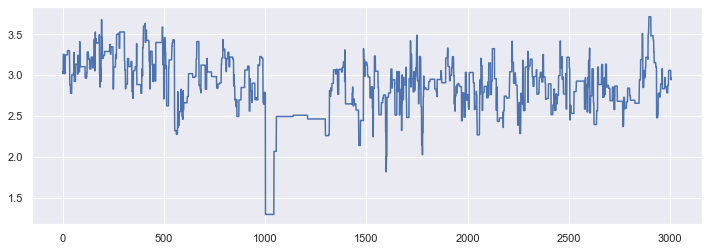

In [35]:
plt.plot(samplings[0,:])
plt.savefig('gk_all_sampling_0.png')

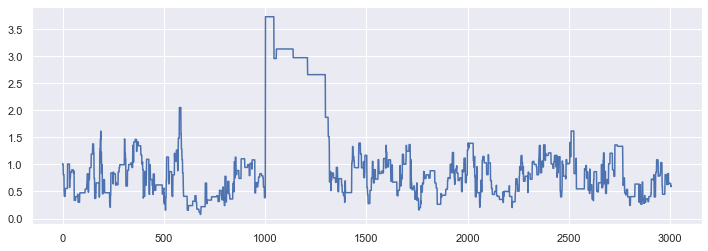

In [36]:
plt.plot(samplings[1,:])
plt.savefig('gk_all_sampling_1.png')

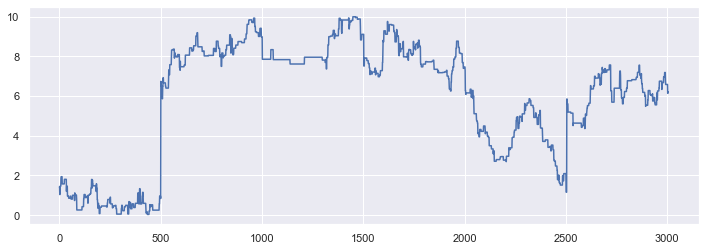

In [37]:
plt.plot(samplings[2,:])
plt.savefig('gk_all_sampling_2.png')

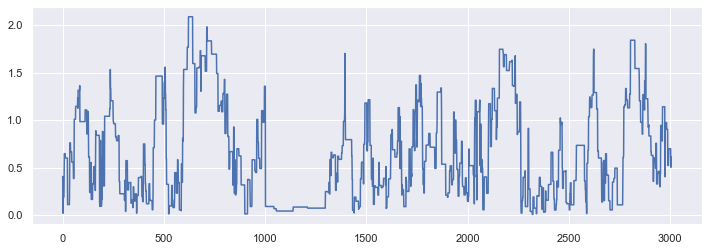

In [38]:
plt.plot(samplings[3,:])
plt.savefig('gk_all_sampling_3.png')

#### Histogram plot

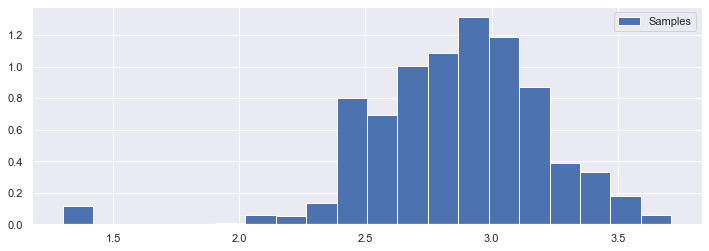

In [39]:
plt.hist(samplings[0, :], bins = 20, density = True, label = 'Samples')
plt.legend()
plt.savefig('gk_all_histogram_0.png')

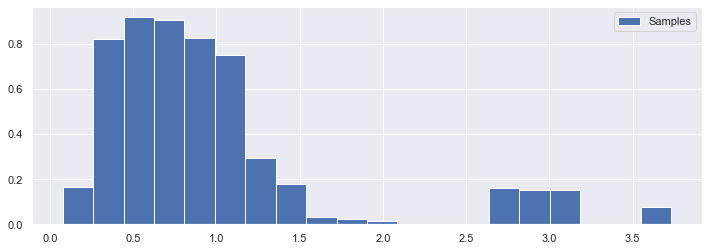

In [40]:
plt.hist(samplings[1, :], bins = 20, density = True, label = 'Samples')
plt.legend()
plt.savefig('gk_all_histogram_1.png')

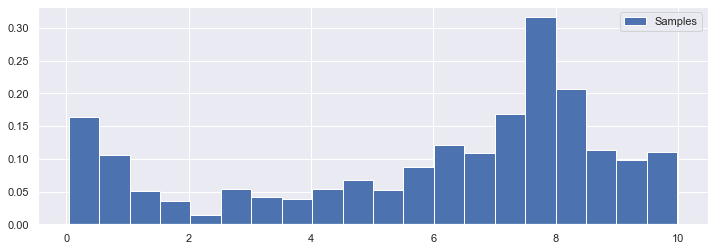

In [41]:
plt.hist(samplings[2, :], bins = 20, density = True, label = 'Samples')
plt.legend()
plt.savefig('gk_all_histogram_2.png')

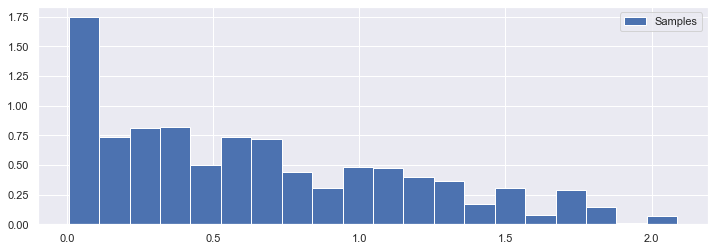

In [42]:
plt.hist(samplings[3, :], bins = 20, density = True, label = 'Samples')
plt.legend()
plt.savefig('gk_all_histogram_3.png')

#### Histogram and kernel plots

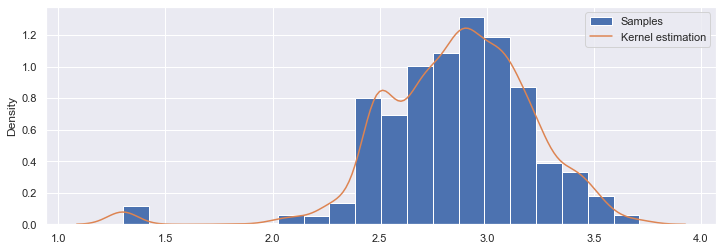

In [43]:
plt.hist(samplings[0, :], bins = 20, density = True, label='Samples')
sns.kdeplot(samplings[0, :], label='Kernel estimation')
plt.legend()
plt.savefig('gk_all_histogram_kernel_0.png')

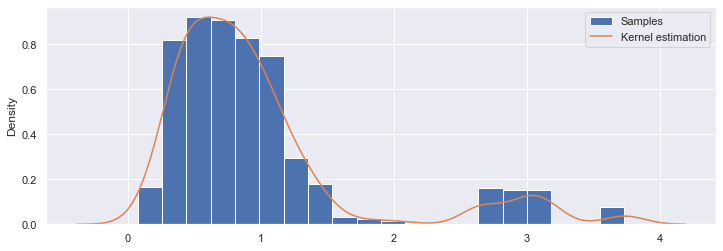

In [44]:
plt.hist(samplings[1, :], bins = 20, density = True, label='Samples')
sns.kdeplot(samplings[1, :], label='Kernel estimation')
plt.legend()
plt.savefig('gk_all_histogram_kernel_1.png')

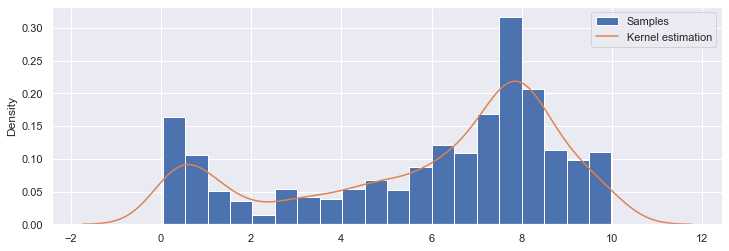

In [45]:
plt.hist(samplings[2, :], bins = 20, density = True, label='Samples')
sns.kdeplot(samplings[2, :], label='Kernel estimation')
plt.legend()
plt.savefig('gk_all_histogram_kernel_2.png')

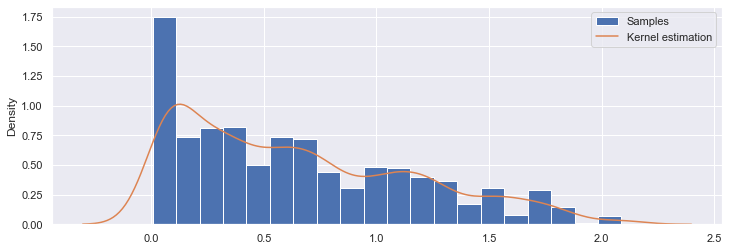

In [46]:
plt.hist(samplings[3, :], bins = 20, density = True, label='Samples')
sns.kdeplot(samplings[3, :], label='Kernel estimation')
plt.legend()
plt.savefig('gk_all_histogram_kernel_3.png')

#### Plot of a single coupling

In [47]:
red_chain, blue_chain, acc1_all, acc2_all = abc_coupling_gandk(iterations, S2, y_obs, 0.6)  


/tmp/ipykernel_6556/1251087141.py:46: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  theta1[0,:]=[a1_0,b1_0,g1_0,k1_0]
/tmp/ipykernel_6556/1251087141.py:58: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  theta2[0,:]=[a2_0,b2_0,g2_0,k2_0]


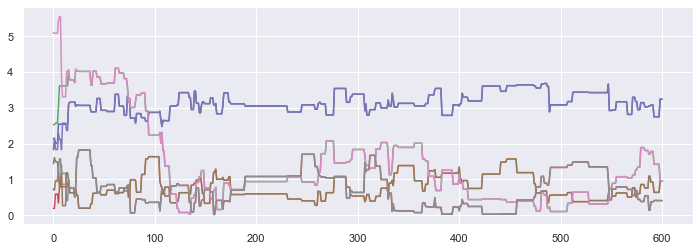

In [48]:
plt.plot(red_chain)
plt.plot(blue_chain)
plt.savefig('gk_all_chain_meeeting.png')

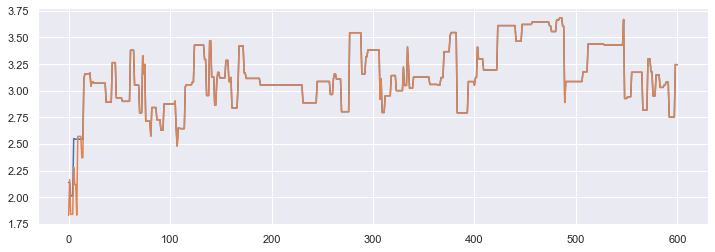

In [59]:
plt.plot(red_chain[:,0])
plt.plot(blue_chain[:,0])
plt.savefig('gk_all_chain_meeeting_0.png')

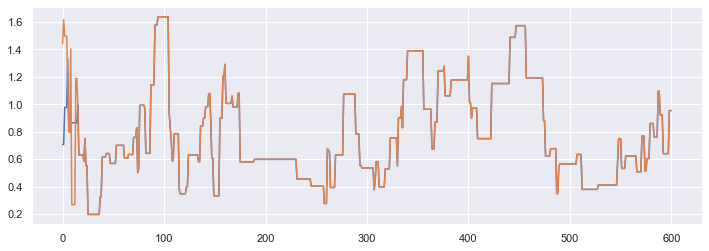

In [60]:
plt.plot(red_chain[:,1])
plt.plot(blue_chain[:,1])
plt.savefig('gk_all_chain_meeeting_1.png')

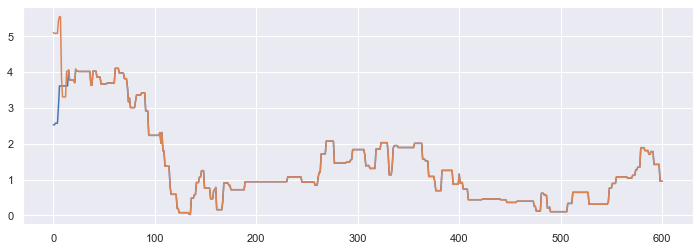

In [61]:
plt.plot(red_chain[:,2])
plt.plot(blue_chain[:,2])
plt.savefig('gk_all_chain_meeeting_2.png')

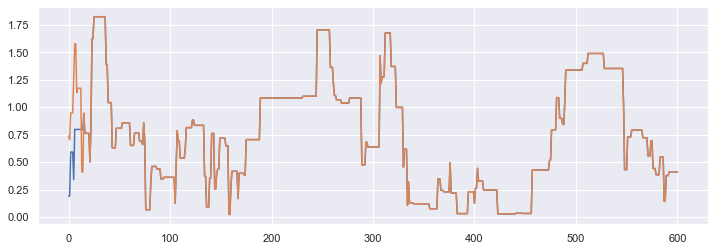

In [62]:
plt.plot(red_chain[:,3])
plt.plot(blue_chain[:,3])
plt.savefig('gk_all_chain_meeeting_3.png')